In [1]:
runs = 200

In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0
        !pip install tensorflow-probability==0.8.0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)


TFP Version 0.8.0
TF  Version 2.0.0


In [4]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

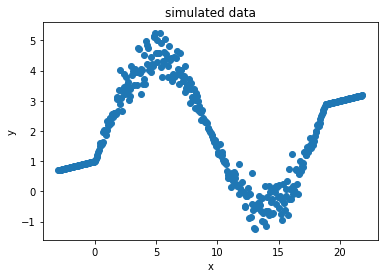

In [5]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_aleatoric = Model(inputs=inputs, outputs=dist)
model_aleatoric.compile(Adam(), loss=NLL) 

In [7]:
model_aleatoric.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
___________________________________________________________

In [8]:
#history = model_aleatoric.fit(x, y, epochs=5000, verbose=0,batch_size=32)

In [9]:
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.show()

In [10]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_aleatoric_weights.hdf5")
model_aleatoric.load_weights("model_aleatoric_weights.hdf5")

In [11]:
model_aleatoric_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_sd = Model(inputs=inputs, outputs=dist.stddev())

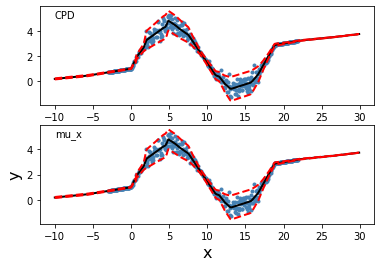

In [12]:
def make_no_bayes_plot(ax, text, model_mu, model_sig, add_std=False, stretch=1, alpha_data=1.0):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    mus_pred = model_mu.predict(x_pred)
    sig_pred = model_sig.predict(x_pred)
    ax.plot(x_pred,mus_pred * stretch,color="black",linewidth=2)
    if add_std:
        ax.plot(x_pred,mus_pred + 2 * sig_pred,color="red",linestyle="--",linewidth=2) 
        ax.plot(x_pred,mus_pred - 2 * sig_pred,color="red",linestyle="--",linewidth=2)
    ax.text(-10,5,text)

f,ax = plt.subplots(2)
make_no_bayes_plot(ax[0],"CPD", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
make_no_bayes_plot(ax[1],r"mu_x", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Bayesian Model using VI

In [13]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(), loss=NLL) 

Instructions for updating:
Please use `layer.add_weight` method instead.


In [14]:
model_vi.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 20)                80        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [15]:
# history = model_vi.fit(x, y, epochs=4000, verbose=0,batch_size=32)
# #around 10 min
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# plt.show()

In [16]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_epistemic_weights.hdf5", "model_aleatoric_epistemic_weights.hdf5")
model_vi.load_weights("model_aleatoric_epistemic_weights.hdf5")

model_vi_mean = Model(inputs=inputs, outputs=dist.mean())
model_vi_sd = Model(inputs=inputs, outputs=dist.stddev())

In [17]:
# Predicting the mu and sigma
x_pred = np.arange(-10,30,0.1)
vi_mus =np.zeros((runs,len(x_pred)))
vi_stds=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_mus[i,:]=np.reshape(model_vi_mean.predict(x_pred),len(x_pred))
    vi_stds[i,:]=np.reshape(model_vi_sd.predict(x_pred),len(x_pred))

### Parameter $\mu_x$ for several runs 

We start several runs and plot the parameters $\mu_x$

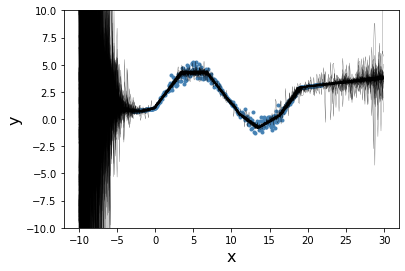

In [18]:
def make_bayes_plot_runs(ax, preds, runs = 100,alpha_data=1):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    for i in range(0,runs):
      ax.plot(x_pred, preds[i,0:400],color="black",linewidth=0.2)
  
ax = plt.subplot()
make_bayes_plot_runs(ax, vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

#### Taking statistics of the different runs 

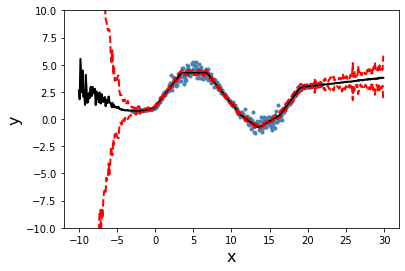

In [19]:
def make_bayes_plot_runs_avg(ax, preds, runs = 100,alpha_data=1):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd      
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=2)
    ax.plot(x_pred,np.mean(preds,axis=0)+2*np.std(preds,axis=0),color="red",linewidth=2,linestyle="--")
    ax.plot(x_pred,np.mean(preds,axis=0)-2*np.std(preds,axis=0),color="red",linewidth=2,linestyle="--")

ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Modeling the CPD


In [20]:
x_pred = np.arange(-10,30,0.1)
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

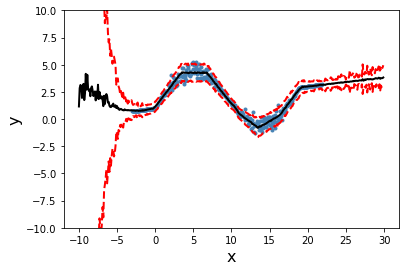

In [21]:
ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## MC Dropout

In [22]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [23]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(), loss=NLL) 

In [24]:
model_mc.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               100500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0   

In [25]:
#history = model_mc.fit(x, y, epochs=20000, verbose=0,batch_size=32)
#dauert ca 20min mit 20000 epochs

In [26]:
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
#model_mc.save_weights('model_mc_weights.hdf5')

In [27]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_weights.hdf5", "model_mc_weights.hdf5")
model_mc.load_weights("model_mc_weights.hdf5")

In [28]:
model_mc_mean = Model(inputs=inputs, outputs=dist_mc.mean())
model_mc_sd = Model(inputs=inputs, outputs=dist_mc.stddev())

In [29]:
# Predicting the mu and sigma
mc_mus=np.zeros((runs,len(x_pred)))
mc_std=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
  mc_mus[i,:]=np.reshape(model_mc_mean.predict(x_pred),len(x_pred))
  mc_std[i,:]=np.reshape(model_mc_sd.predict(x_pred),len(x_pred))

In [30]:
x_pred = np.arange(-10,30,0.1)
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

<Figure size 216x1296 with 0 Axes>

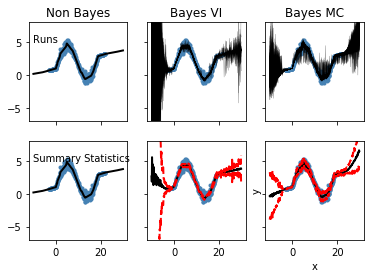

In [31]:
plt.figure(figsize=(3,18))
f,ax = plt.subplots(2,3,sharex=True, sharey=True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-7,8])

make_no_bayes_plot(ax[0,0],r"Runs", model_aleatoric_mean, model_aleatoric_sd, add_std=False)
ax[0,0].set_title('Non Bayes')
make_no_bayes_plot(ax[1,0],r"Summary Statistics", model_aleatoric_mean, model_aleatoric_sd, add_std=False)


ax[0,1].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,1], vi_mus)
make_bayes_plot_runs_avg(ax[1,1], vi_mus)

ax[0,2].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,2], mc_mus)
make_bayes_plot_runs_avg(ax[1,2], mc_mus)
plt.savefig('ch08_good_mu.pdf')

plt.show()

<Figure size 216x1296 with 0 Axes>

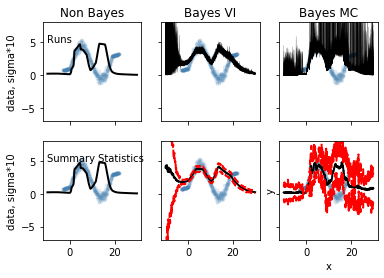

In [32]:
plt.figure(figsize=(3,18))
f,ax = plt.subplots(2,3,sharex=True, sharey=True)

plt.ylim([-7,8])
plt.xlabel('x')
plt.ylabel('y')

make_no_bayes_plot(ax[0,0],r"Runs", model_aleatoric_sd, model_aleatoric_sd, add_std=False,stretch=10, alpha_data=0.1)
ax[0,0].set_title('Non Bayes')
ax[0,0].set_ylabel('data, sigma*10')
make_no_bayes_plot(ax[1,0],r"Summary Statistics", model_aleatoric_sd, model_aleatoric_sd, add_std=False,stretch=10, alpha_data=0.1)
ax[1,0].set_ylabel('data, sigma*10')

ax[0,1].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,1], 10*vi_stds, alpha_data=0.1)
make_bayes_plot_runs_avg(ax[1,1], 10*vi_stds, alpha_data=0.1)

ax[0,2].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,2], 10*mc_std, alpha_data=0.1)
make_bayes_plot_runs_avg(ax[1,2], 10*mc_std, alpha_data=0.1)
plt.savefig('ch08_good_sig.pdf')

plt.show()

<Figure size 216x1296 with 0 Axes>

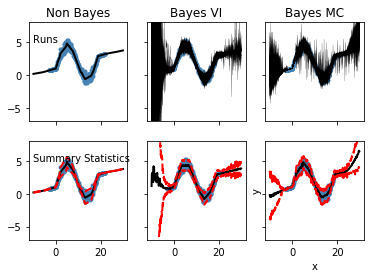

In [33]:
plt.figure(figsize=(3,18))
f,ax = plt.subplots(2,3,sharex=True, sharey=True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-7,8])

make_no_bayes_plot(ax[0,0],r"Runs", model_aleatoric_mean, model_aleatoric_sd, add_std=False)
ax[0,0].set_title('Non Bayes')
make_no_bayes_plot(ax[1,0],r"Summary Statistics", model_aleatoric_mean, model_aleatoric_sd, add_std=True)


ax[0,1].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,1], vi_cpd)
make_bayes_plot_runs_avg(ax[1,1], vi_cpd)

ax[0,2].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,2], mc_cpd)
make_bayes_plot_runs_avg(ax[1,2], mc_cpd)
plt.savefig('ch08_good_mu.pdf')

plt.show()

### Additional Plots

Let's look at the parameters. How are they distributed? It seems that the MC-Dropout results are off-Gaussian.

In [34]:
!pip install statsmodels

You should consider upgrading via the 'pip install --upgrade pip' command.


(array([ 7., 84., 84.,  8., 10.,  3.,  2.,  0.,  1.,  1.]),
 array([1.13952553, 1.27515427, 1.410783  , 1.54641174, 1.68204048,
        1.81766921, 1.95329795, 2.08892668, 2.22455542, 2.36018416,
        2.49581289]),
 <a list of 10 Patch objects>)

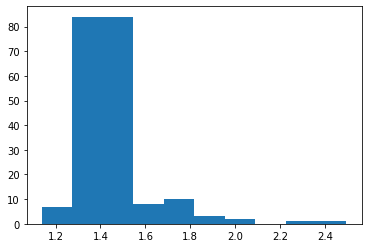

In [35]:
plt.hist(mc_mus[:,200])

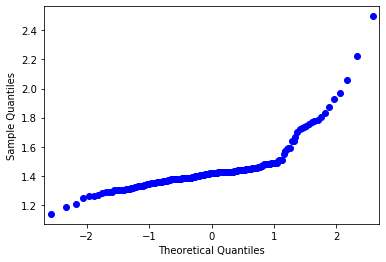

In [36]:
import statsmodels.api as sm
sm.qqplot(mc_mus[:,200])
plt.show()

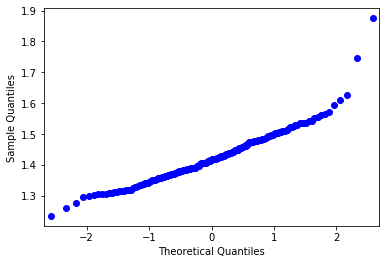

In [37]:
import statsmodels.api as sm
sm.qqplot(vi_mus[:,200])
plt.show()